Удалила "2 Зрелый почерк-(обычный почерк)-2.jpg" (там печатный текст)

# Config

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
cd drive/MyDrive/Colab\ Notebooks/mest

/content/drive/MyDrive/Colab Notebooks/mest


In [3]:
!pip install hydra-core --upgrade

In [4]:
from src.commands import *
import hydra

hydra.core.global_hydra.GlobalHydra.instance().clear()
CONF = hydra_config("config2.yaml")
show_CONF(CONF)

{
        "seed": 42,
        "device": "cpu",
        "save_path": "checkpoints",
        "dataset": {
                "data_pos": "bin/1",
                "data_neg": "bin/0",
                "threshold": 0.999,
                "pos_aug": 22,
                "neg_aug": 2
        },
        "loader": {
                "batch_size": 8
        },
        "classifier": {
                "n_epochs": 30,
                "learning_rate": 0.0001,
                "train": true,
                "path_model": "resnet",
                "path_log": "resnet.pickle"
        }
}


In [5]:
show_CONF(CONF)

{
        "seed": 42,
        "device": "cpu",
        "save_path": "checkpoints",
        "dataset": {
                "data_pos": "bin/1",
                "data_neg": "bin/0",
                "threshold": 0.999,
                "pos_aug": 22,
                "neg_aug": 2
        },
        "loader": {
                "batch_size": 8
        },
        "classifier": {
                "n_epochs": 30,
                "learning_rate": 0.0001,
                "train": true,
                "path_model": "resnet",
                "path_log": "resnet.pickle"
        }
}


# Библиотеки

In [6]:
from hydra import compose, initialize
from omegaconf import OmegaConf
import json, os
import matplotlib.pyplot as plt

from torchvision import datasets, models, transforms
from time import time
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import torch
import os, json, cv2, re
import numpy as np

from src.dataset import My_Dataset, TripletDataset, Emb_Dataset
from src.functions import number_of_parameters, seed_everything, create_model
from src.dataset_fun import split_dataset
from src import siamese, classifier
from src.classifier import get_predictions
from src.train import train, load_logs, load_model
from src.functions import confusion_matrix, distribution
from src.show_fun import show_result, show_images

# train

In [ ]:
pos_dataset, neg_dataset = pos_neg_dataset(CONF)

model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
num_classes = 2
num_non_freeze = 2361346
seed_everything(CONF.seed)
model = create_model(model, num_non_freeze, num_classes).to(CONF.device)
print(f"num parameters = {number_of_parameters(model)}")

dataset = torch.utils.data.ConcatDataset([pos_dataset, neg_dataset])
seed_everything(CONF.seed)
train_dataset, test_dataset = split_dataset(dataset)

common_train(CONF, model, train_dataset, test_dataset, kind="cl")
load_best_model(CONF, model, train_dataset, test_dataset, kind="cl")

Positive dataset: 484    (22)
Negative dataset: 448    (224)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 117MB/s]


num parameters = 2361346
split_dataset: Train: 745 Test: 187 Total: 932
train: started, kind = 'cl'
# 2024-05-28 20:10:48 Epoch  1 train/val: loss 0.30789/0.39391, acc: 89.396%/ 82.353%
# 2024-05-28 20:10:50 Epoch  2 train/val: loss 0.22982/0.34323, acc: 92.483%/ 83.957%
# 2024-05-28 20:10:53 Epoch  3 train/val: loss 0.17591/0.33391, acc: 95.034%/ 83.957%
# 2024-05-28 20:10:56 Epoch  4 train/val: loss 0.15626/0.31373, acc: 95.168%/ 85.561%
# 2024-05-28 20:10:59 Epoch  5 train/val: loss 0.14512/0.34916, acc: 96.107%/ 82.888%
# 2024-05-28 20:11:01 Epoch  6 train/val: loss 0.11966/0.34966, acc: 97.852%/ 82.888%
# 2024-05-28 20:11:04 Epoch  7 train/val: loss 0.09474/0.34307, acc: 98.523%/ 81.818%
# 2024-05-28 20:11:06 Epoch  8 train/val: loss 0.09432/0.35052, acc: 98.792%/ 81.818%
# 2024-05-28 20:11:09 Epoch  9 train/val: loss 0.06389/0.32997, acc: 98.926%/ 85.027%
# 2024-05-28 20:11:12 Epoch 10 train/val: loss 0.06010/0.33446, acc: 99.732%/ 86.096%
# 2024-05-28 20:11:14 Epoch 11 train/val

# eval

0.981404958677686


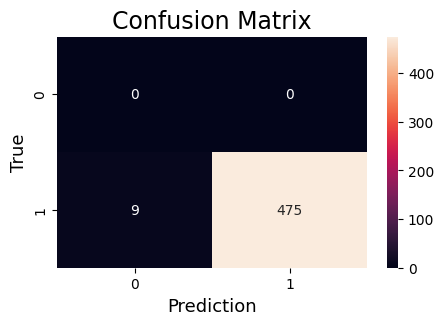

[[  0   0]
 [  9 475]]


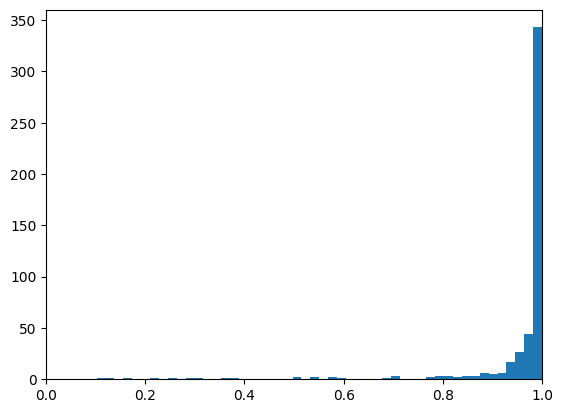

In [ ]:
X, y_true, y_pred, y_prob = get_predictions(model, pos_dataset,
                                            CONF.loader.batch_size, CONF.device)
print(accuracy_score(y_pred, y_true))
# 0.987603305785124
# array([[  0,   0],
#        [  6, 478]])
print(confusion_matrix(y_true, y_pred))
distribution(y_prob)

0.9620535714285714


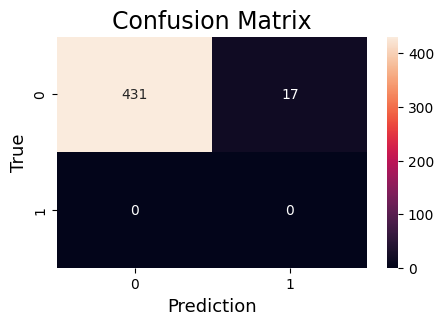

[[431  17]
 [  0   0]]


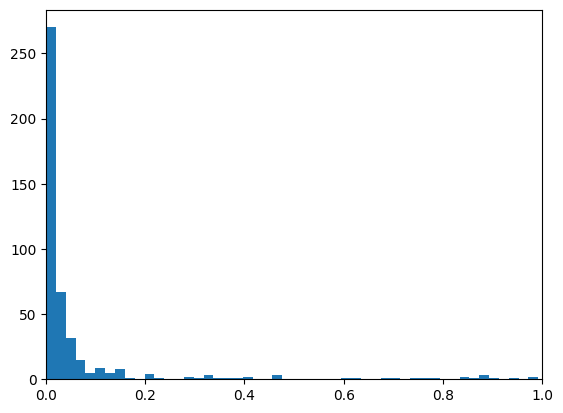

In [ ]:
X, y_true, y_pred, y_prob = get_predictions(model, neg_dataset,
                                            CONF.loader.batch_size, CONF.device)
print(accuracy_score(y_pred, y_true))
# 0.96875
# array([[435,  13],
#        [  0,   0]])
print(confusion_matrix(y_true, y_pred))
distribution(y_prob)

0.9721030042918455


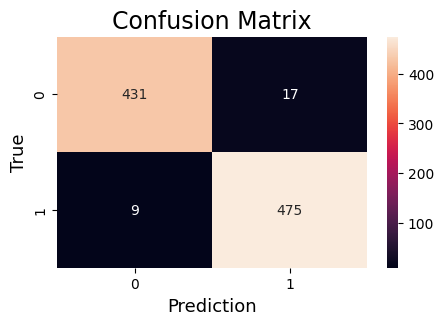

[[431  17]
 [  9 475]]


In [ ]:
X, y_true, y_pred, y_prob = get_predictions(model, dataset,
                                            CONF.loader.batch_size, CONF.device)
print(accuracy_score(y_pred, y_true))
print(confusion_matrix(y_true, y_pred))
# 0.9785407725321889
# array([[435,  13],
#        [  6, 478]])

# show

prob < 0.6
count : 16 out of 484
pic idx : [92, 254, 201, 461, 67, 420, 297, 430]


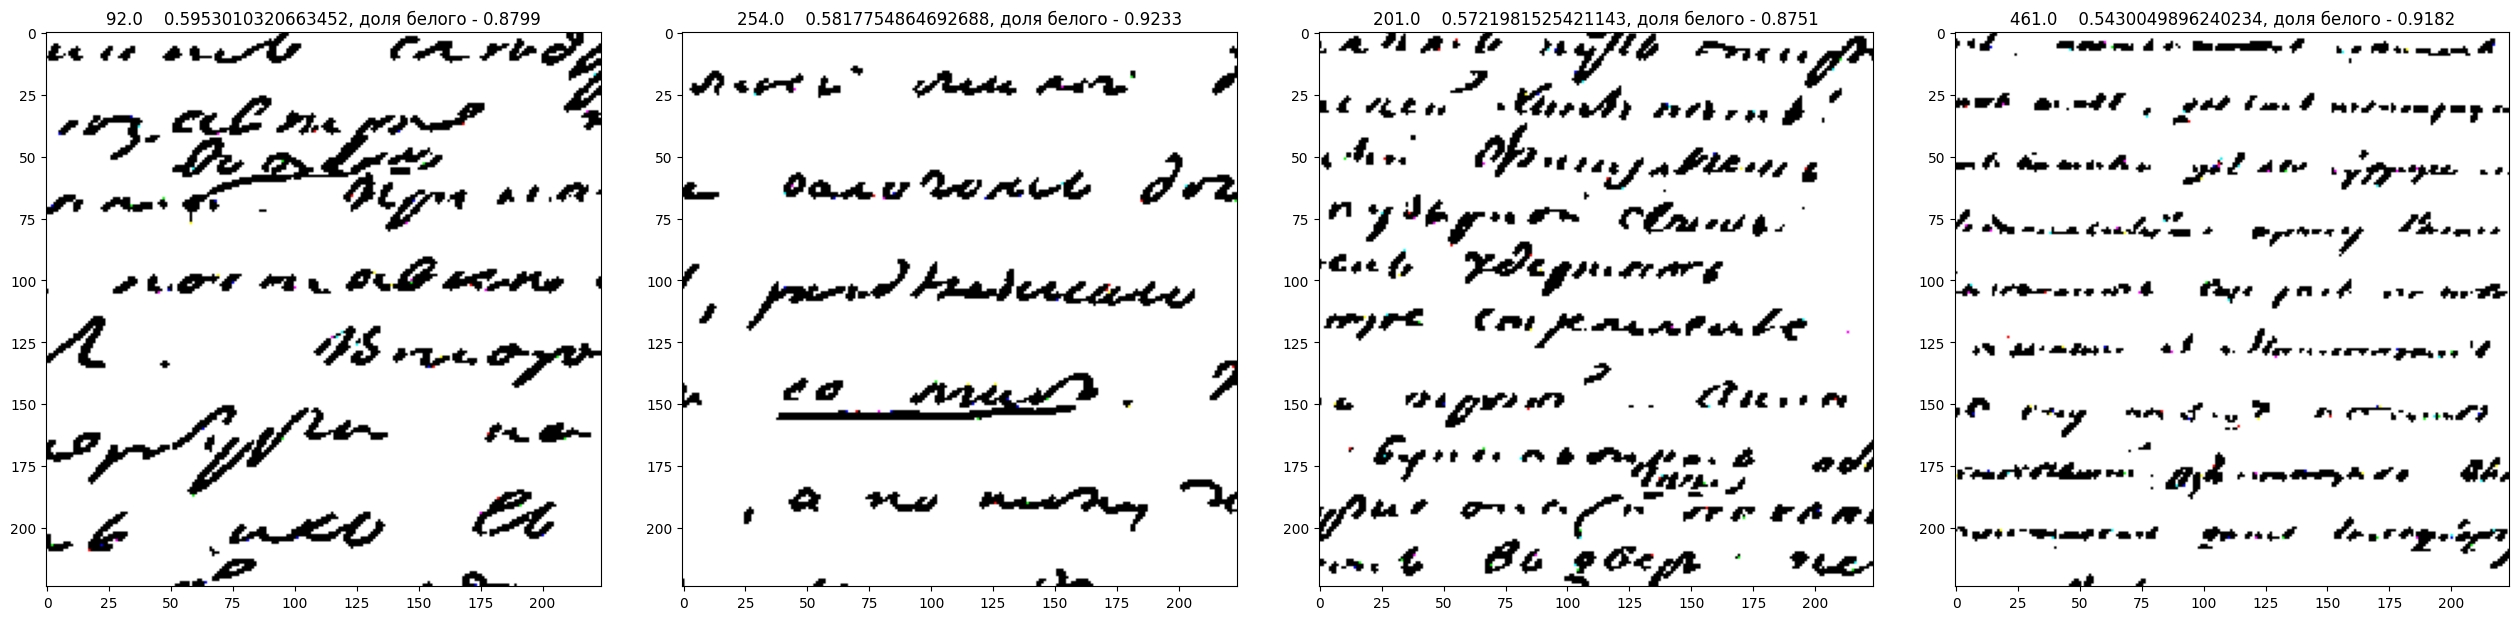

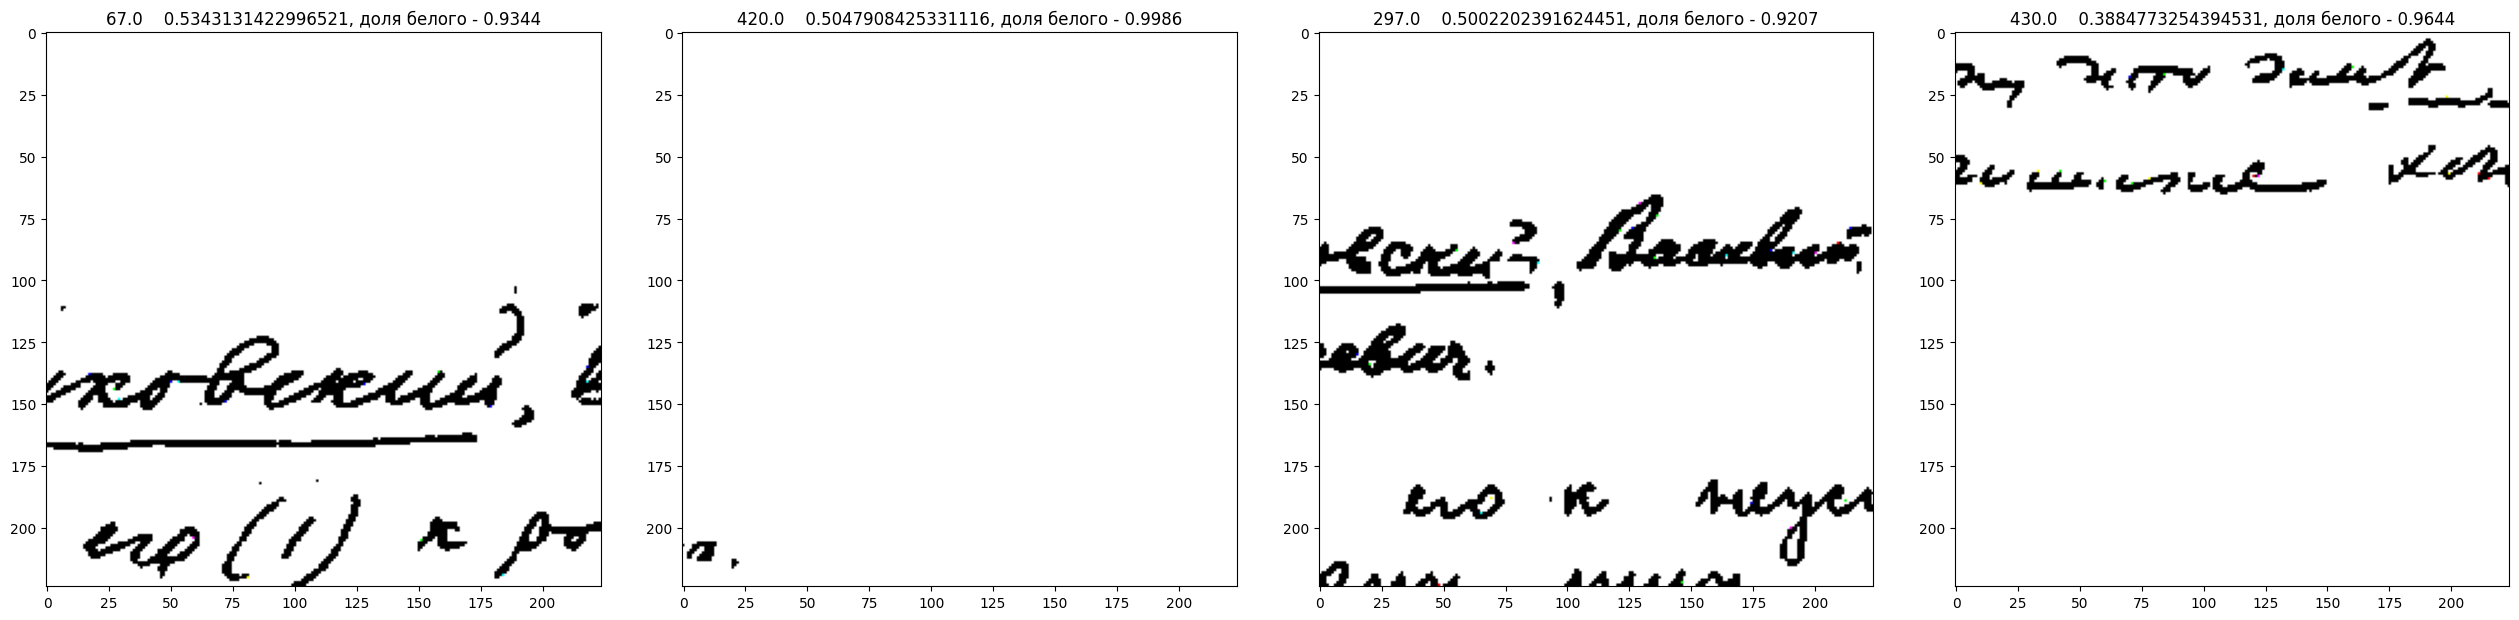

In [ ]:
X, y_true, y_pred, y_prob, indices = show_result(model, pos_dataset, 0.6,
                                   CONF.loader.batch_size, CONF.device,
                                   greater = False, col = 8,
                                   sort = True)

In [ ]:
X, y_true, y_pred, y_prob, indices = show_result(model, neg_dataset, 0.4,
                                   CONF.loader.batch_size, CONF.device,
                                   greater = True, col = 24,
                                   sort = True)

Output hidden; open in https://colab.research.google.com to view.

# on the entire dataset

In [ ]:
X, y_true, y_pred, y_prob, indices = show_result(model, neg_dataset, 0,
                                   CONF.loader.batch_size, CONF.device,
                                   greater = True, col = 448,
                                   sort = True)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
X, y_true, y_pred, y_prob, indices = show_result(model, pos_dataset, 0,
                                   CONF.loader.batch_size, CONF.device,
                                   greater = True, col = 484,
                                   sort = True)

Output hidden; open in https://colab.research.google.com to view.